In [2]:
pip install opencv-python

    100% |████████████████████████████████| 28.2MB 61kB/s  eta 0:00:011
    100% |████████████████████████████████| 20.2MB 85kB/s  eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [41]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    AspectAwarePreprocessor, \
    MeanSubtractionPreProcessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from imutils import paths
import numpy as np
import os

In [42]:
args = {
    'dataset':r"/home/mhasan3/Desktop/WorkFolder/cellImages4/"}

In [43]:
# construct the image generator
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2, 
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest')

In [44]:
# grab the list of images that we'll be describing then extract the class 
# label names from the imagePaths
imagePaths = list(paths.list_images(args['dataset']))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

In [45]:
# initialise the image preprocessor
msp = MeanSubtractionPreProcessor()
aap = AspectAwarePreprocessor(224,224)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixels
sdl = SimpleDatasetLoader(preprocessors=[msp, aap, iap])
data, labels = sdl.load(imagePaths, verbose=500)
#data = data.astype('float') / 255.0

[INFO] processed 500/3071
[INFO] processed 1000/3071
[INFO] processed 1500/3071
[INFO] processed 2000/3071
[INFO] processed 2500/3071
[INFO] processed 3000/3071


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


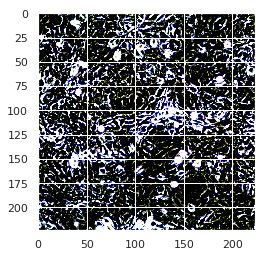

In [46]:
import cv2
import matplotlib.pyplot as plt
sample_image = cv2.cvtColor(data[2500], cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)

In [47]:
# partition the data into training and test splits
trainx, testx, trainy, testy = train_test_split(data,
                                                labels,
                                                test_size=0.25,
                                                random_state=42)

# convert labels from integers into vectors
le = LabelBinarizer()
trainy = le.fit_transform(trainy)
testy = le.transform(testy)

In [48]:
le.classes_

array(['3T3', 'MG63', 'hASC'], dtype='<U4')

In [49]:
# load the VGG16 network ensuring the head FC layer sets are left off
baseModel = VGG16(weights='imagenet', include_top=False, 
                  input_tensor=Input(shape=(224, 224, 3))) # type: Model

# initialise the new head of the network, a set of FC layers followed by 
# softmax
headModel = FCHeadNet.builld(baseModel, len(classNames), D=256) # type: Model

# place the head FC model on top of the base model - this will be the actual
# model to train
model = Model(inputs=baseModel.input, outputs=headModel)

(?, 7, 7, 512)


In [50]:
# loop over all the layers in the base model and freeze them
for layer in baseModel.layers:
    layer.trainable = False

In [51]:
# compile and optimise model
opt = RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# train the head for few epochs
model.fit_generator(aug.flow(trainx, trainy, batch_size=32),
                    validation_data=(testx, testy),
                    epochs=25,
                    steps_per_epoch=len(trainx) // 32,
                    verbose=1)

Epoch 1/25
72/72 [==============================] - 27s 378ms/step - loss: 10.6887 - acc: 0.3287 - val_loss: 10.7034 - val_acc: 0.3359
Epoch 2/25
72/72 [==============================] - 27s 376ms/step - loss: 10.7641 - acc: 0.3322 - val_loss: 10.7034 - val_acc: 0.3359
Epoch 3/25
72/72 [==============================] - 27s 374ms/step - loss: 10.7648 - acc: 0.3322 - val_loss: 10.7034 - val_acc: 0.3359
Epoch 4/25
72/72 [==============================] - 27s 376ms/step - loss: 10.7641 - acc: 0.3322 - val_loss: 10.7034 - val_acc: 0.3359
Epoch 5/25
72/72 [==============================] - 27s 376ms/step - loss: 10.7643 - acc: 0.3322 - val_loss: 10.7034 - val_acc: 0.3359
Epoch 6/25
72/72 [==============================] - 28s 387ms/step - loss: 10.7632 - acc: 0.3322 - val_loss: 10.7034 - val_acc: 0.3359
Epoch 7/25
72/72 [==============================] - 27s 377ms/step - loss: 10.7628 - acc: 0.3322 - val_loss: 10.7034 - val_acc: 0.3359
Epoch 8/25
72/72 [==============================] - 28s

In [52]:
# evaluate the network
preds = model.predict(testx, batch_size=32)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1),
                            target_names=classNames))

              precision    recall  f1-score   support

         3T3       0.95      1.00      0.98       249
        MG63       1.00      0.97      0.99       258
        hASC       1.00      0.98      0.99       261

    accuracy                           0.98       768
   macro avg       0.98      0.98      0.98       768
weighted avg       0.99      0.98      0.98       768



In [53]:
# now that FC layers have been trained, lets unfreeze the final set of CONV 
# layers and make them trainable
for layer in baseModel.layers[14:]:
    layer.trainable = True

In [54]:
# for changes to take effect we need to recompile model
opt = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
H = model.fit_generator(aug.flow(trainx, trainy, batch_size=32),
                    validation_data=(testx, testy),
                    epochs=10,
                    steps_per_epoch=len(trainx) // 32,
                    verbose=1)

Epoch 1/10
72/72 [==============================] - 30s 410ms/step - loss: 1.0360 - acc: 0.9023 - val_loss: 0.1229 - val_acc: 0.9609
Epoch 2/10
72/72 [==============================] - 29s 406ms/step - loss: 0.0515 - acc: 0.9848 - val_loss: 0.0174 - val_acc: 0.9961
Epoch 3/10
72/72 [==============================] - 29s 406ms/step - loss: 0.0215 - acc: 0.9944 - val_loss: 0.0269 - val_acc: 0.9922
Epoch 4/10
72/72 [==============================] - 29s 408ms/step - loss: 0.0342 - acc: 0.9900 - val_loss: 0.0292 - val_acc: 0.9909
Epoch 5/10
72/72 [==============================] - 29s 406ms/step - loss: 0.0214 - acc: 0.9926 - val_loss: 0.0141 - val_acc: 0.9987
Epoch 6/10
72/72 [==============================] - 29s 405ms/step - loss: 0.0184 - acc: 0.9948 - val_loss: 0.0187 - val_acc: 0.9961
Epoch 7/10
72/72 [==============================] - 29s 407ms/step - loss: 0.0113 - acc: 0.9965 - val_loss: 0.0160 - val_acc: 0.9974
Epoch 8/10
72/72 [==============================] - 29s 410ms/step - 

In [55]:
# evaluate the network again
preds = model.predict(testx, batch_size=32)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1),
                            target_names=classNames))

              precision    recall  f1-score   support

         3T3       1.00      1.00      1.00       249
        MG63       1.00      1.00      1.00       258
        hASC       1.00      1.00      1.00       261

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [56]:
# save serialised model
model.save('keras_finetune_acc1.00.pth')

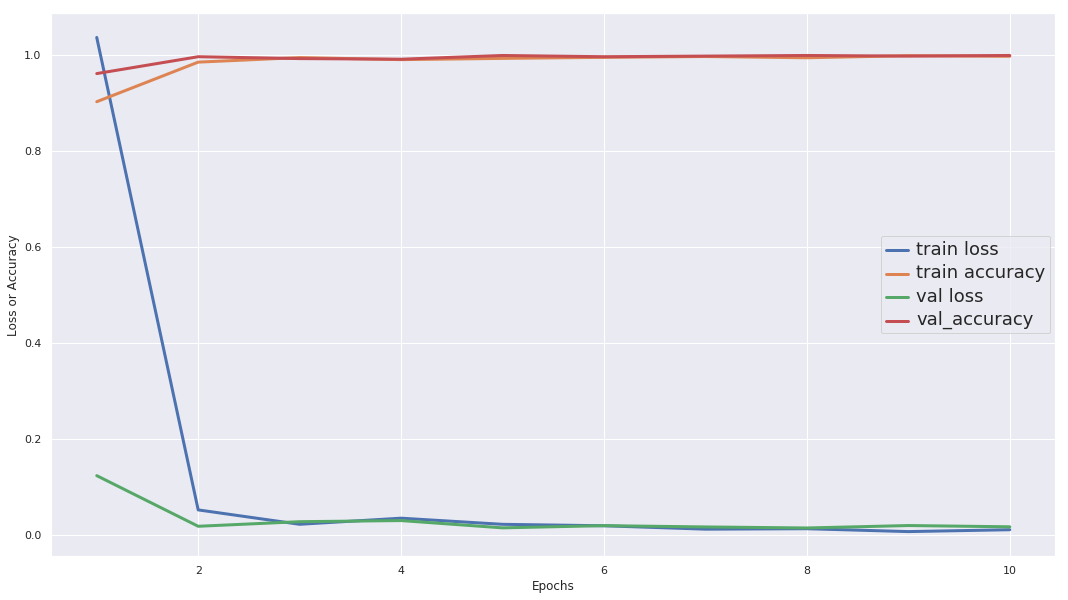

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(1,10+1)
loss = H.history['loss']
accuracy = H.history['acc']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_acc']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

#%%

sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy.argmax(axis=1),
                 preds.argmax(axis=1))
cm

array([[249,   0,   0],
       [  1, 257,   0],
       [  0,   0, 261]])

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

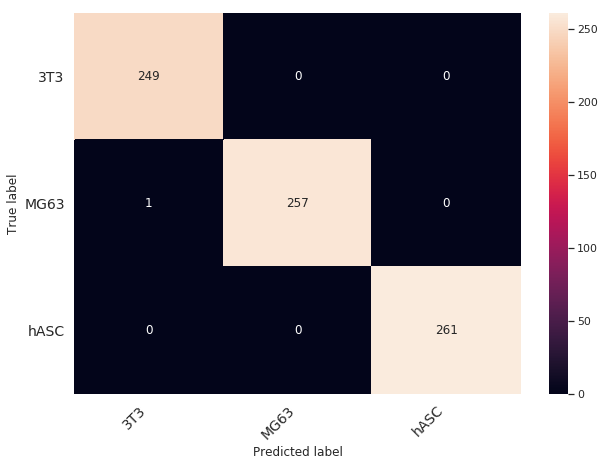

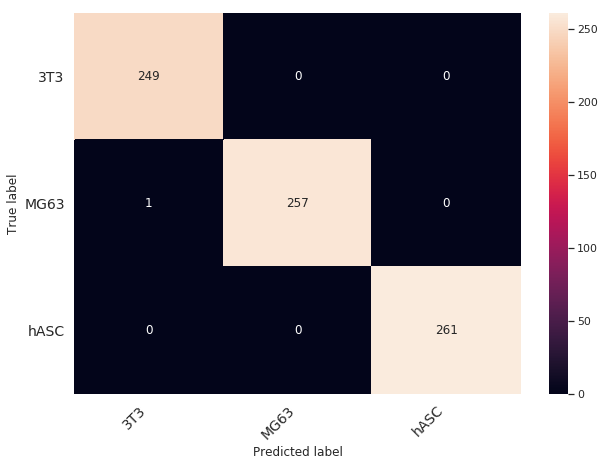

In [67]:
print_confusion_matrix(cm, classNames)